Tensorflow version 1.2.0
Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


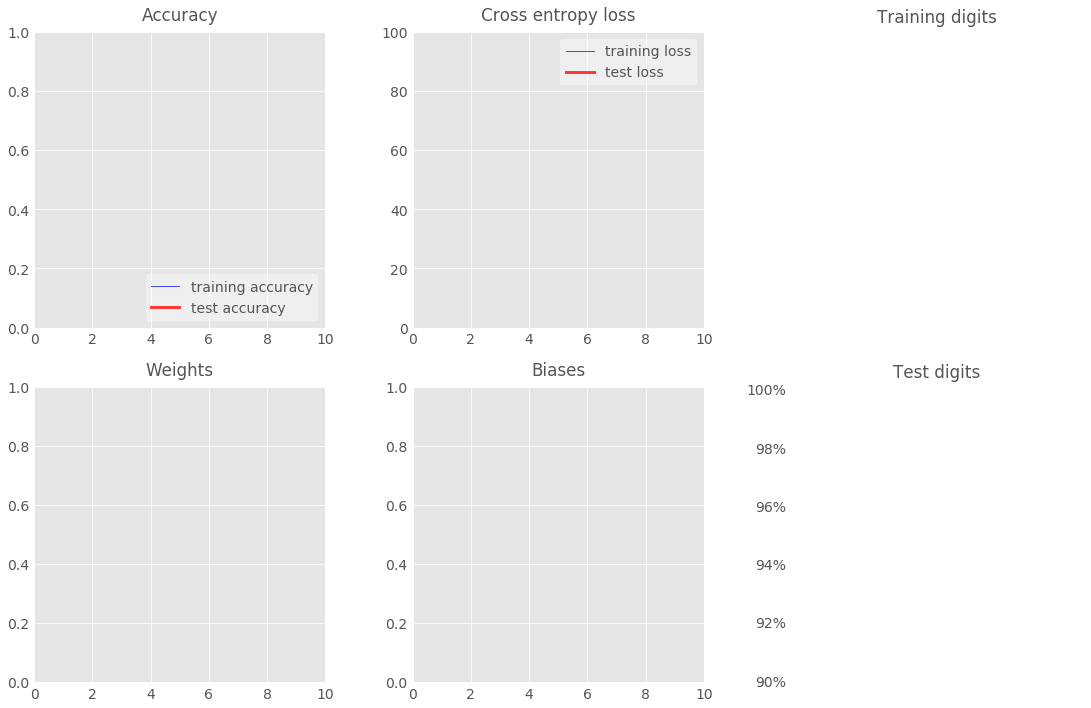

max test accuracy: 0


In [1]:
# encoding: UTF-8
# Copyright 2016 Google.com
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import tensorflow as tf
import tensorflowvisu
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
print("Tensorflow version " + tf.__version__)
tf.set_random_seed(0)

# neural network with 1 layer of 10 softmax neurons
#
# · · · · · · · · · ·       (input data, flattened pixels)       X [batch, 784]        # 784 = 28 * 28
# \x/x\x/x\x/x\x/x\x/    -- fully connected layer (softmax)      W [784, 10]     b[10]
#   · · · · · · · ·                                              Y [batch, 10]

# The model is:
#
# Y = softmax( X * W + b)
#              X: matrix for 100 grayscale images of 28x28 pixels, flattened (there are 100 images in a mini-batch)
#              W: weight matrix with 784 lines and 10 columns
#              b: bias vector with 10 dimensions
#              +: add with broadcasting: adds the vector to each line of the matrix (numpy)
#              softmax(matrix) applies softmax on each line
#              softmax(line) applies an exp to each value then divides by the norm of the resulting line
#              Y: output matrix with 100 lines and 10 columns

# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

# input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
# correct answers will go here
Y_ = tf.placeholder(tf.float32, [None, 10])
# weights W[784, 10]   784=28*28
W = tf.Variable(tf.zeros([784, 10]))
# biases b[10]
b = tf.Variable(tf.zeros([10]))

# flatten the images into a single line of pixels
# -1 in the shape definition means "the only possible dimension that will preserve the number of elements"
XX = tf.reshape(X, [-1, 784])

# The model
Y = tf.nn.softmax(tf.matmul(XX, W) + b)

# loss function: cross-entropy = - sum( Y_i * log(Yi) )
#                           Y: the computed output vector
#                           Y_: the desired output vector

# cross-entropy
# log takes the log of each element, * multiplies the tensors element by element
# reduce_mean will add all the components in the tensor
# so here we end up with the total cross-entropy for all images in the batch
cross_entropy = -tf.reduce_mean(Y_ * tf.log(Y)) * 1000.0  # normalized for batches of 100 images,
                                                          # *10 because  "mean" included an unwanted division by 10

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training, learning rate = 0.005
train_step = tf.train.GradientDescentOptimizer(0.005).minimize(cross_entropy)

# matplotlib visualisation
allweights = tf.reshape(W, [-1])
allbiases = tf.reshape(b, [-1])
I = tensorflowvisu.tf_format_mnist_images(X, Y, Y_)  # assembles 10x10 images by default
It = tensorflowvisu.tf_format_mnist_images(X, Y, Y_, 1000, lines=25)  # 1000 images on 25 lines
datavis = tensorflowvisu.MnistDataVis()

# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


# You can call this function in a loop to train the model, 100 images at a time
def training_step(i, update_test_data, update_train_data):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)

    # compute training values for visualisation
    if update_train_data:
        a, c, im, w, b = sess.run([accuracy, cross_entropy, I, allweights, allbiases], feed_dict={X: batch_X, Y_: batch_Y})
        datavis.append_training_curves_data(i, a, c)
        datavis.append_data_histograms(i, w, b)
        datavis.update_image1(im)
        print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c))

    # compute test values for visualisation
    if update_test_data:
        a, c, im = sess.run([accuracy, cross_entropy, It], feed_dict={X: mnist.test.images, Y_: mnist.test.labels})
        datavis.append_test_curves_data(i, a, c)
        datavis.update_image2(im)
        print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))

    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y})


datavis.animate(training_step, iterations=2000+1, train_data_update_freq=10, test_data_update_freq=50, more_tests_at_start=True)

# to save the animation as a movie, add save_movie=True as an argument to datavis.animate
# to disable the visualisation use the following line instead of the datavis.animate line
# for i in range(2000+1): training_step(i, i % 50 == 0, i % 10 == 0)

print("max test accuracy: " + str(datavis.get_max_test_accuracy()))

# final max test accuracy = 0.9268 (10K iterations). Accuracy should peak above 0.92 in the first 2000 iterations.
